# Region detection with Tensorflow

In this notebook we will explore and end-to-end data generation and machine learning project.

That said, you will learn both programming and applied deep learning concepts.

The project is based on deep learning framework [Tensorflow](https://www.tensorflow.org/) and some add-ons.

We start by importing all required tools at once, letting the discussion of their use for later.

In [1]:
from majordome.ml.tf_common import plot_history
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow_addons.losses import GIoULoss
from tensorflow_addons.losses import giou_loss
import json
import numpy as np
import tensorflow as tf

%matplotlib inline

Since data will be generated withing this notebook and to enforce repeatable training, it is important to seed RNG utilities.

Keras API of Tensorflow provides [this](https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed) utility function to encapsulate all seeding process.

In [20]:
tf.keras.utils.set_random_seed(seed=42)

Since we will be working with deep convolutional neural networks (CNN) we can take profit from GPU acceleration.

This project was designed to be able to run on CPU's as well but keep in mind that any serious CNN application will require (multi-)GPU.

The following line checks the available physical devices.

In [2]:
tf.config.list_physical_devices("GPU")

[]

The goal of the project is to detect a bounding box around a rectangle present in an image.

To train the model we need first to generate the data for training and testing.

We will deal with two levels of difficulty of detection during this tutorial.

In the first level we will simply look for an homogeneous square over an homogeneous background.

Next we extend our study to noisy images, what could make CNN learning more difficult.

Using [NumPy](https://numpy.org/) we can easily allocate a matrix for representing an image.

Next cell provides and test a function for creating the *easy* images.

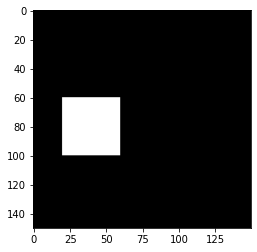

In [26]:
def gen_simple_image(img_size, x, y, h, w):
    """ Create a simple black background with a white square.
    
    Parameters
    ----------
    img_size: int
        Full square image side length.
    x: int
        Horizontal coordinate of top-left corner of square.
    y: int
        Vertical coordinate of top-left corner of square.
    h: int
        Height of square over background.
    w: int
        Width of square over background.
    
    Returns
    -------
    np.ndarray[float]
        Array with 2D image data.
    """
    img = np.zeros((img_size, img_size))
    img[y:y + h, x:x + w] = 1
    return img


_ = plt.imshow(gen_simple_image(img_size=150, x=20, y=60, h=40, w=40), cmap="gray")

Generating *hard* images is no different from that with the *easy* ones in logic.

The main different is the use of random number generators used for background/foreground creation.

We have also added optional parameters for setting foreground and background intensity levels.

You might wish to try later playing (and overlapping) these ranges to see impact on model.

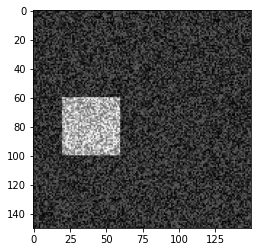

In [28]:
def gen_hard_image(img_size, x, y, h, w, brng=(0, 100), frng=(100, 255)):
    """ Create a noisy background with a noisy lighter square.
    
    Parameters
    ----------
    img_size: int
        Full square image side length.
    x: int
        Horizontal coordinate of top-left corner of square.
    y: int
        Vertical coordinate of top-left corner of square.
    h: int
        Height of square over background.
    w: int
        Width of square over background.
    brng: tuple[int, int]
        Intensity range for background pixels.
    frng: tuple[int, int]
        Intensity range for foreground pixels.
        
    Returns
    -------
    np.ndarray[float]
        Array with 2D image data.
    """
    img = np.random.randint(*brng, size=(img_size, img_size))
    img[y:y + h, x:x + w] = np.random.randint(*frng, size=(h, w))
    return img


_ = plt.imshow(gen_hard_image(img_size=150, x=20, y=60, h=40, w=40), cmap="gray")

In [21]:
def gen_rect(img_size, sqr_size, pad, mode="hard"):
    """ Create a dummy rectangle image over a background.
    
    Parameters
    ----------
    img_size, sqr_size, pad, mode="hard"
    """
    # Generate a point in the upper left region.
    x, y = np.random.randint(0, img_size // 2, 2)

    # Generate a random width and height.
    w, h = np.random.randint(sqr_size // 2, sqr_size , 2)

    # Apply bound to height and width.
    h = img_size - y - 1 if y + h > img_size else h
    w = img_size - x - 1 if x + w > img_size else w

    # Select method of image generation.
    img = gen_hard_image(img_size, x, y, h, w) if mode == "hard" \
        else gen_simple_image(img_size, x, y, h, w)

    # Notice the *pad* for allowing a broader bounding box.
    # For GIoULoss: [y_min, x_min, y_max, x_max]
    bbox = [
        max(y - pad, 0),
        max(x - pad, 0), 
        y + h + pad,
        x + w + pad
        ]
    return img, bbox

In [ ]:
def create_data(num_imgs, img_size, pad=0, sqr_size=None):
    """ Create database of images and labels. """
    bbox = np.empty((num_imgs, 4), dtype=float)
    imgs = np.empty((num_imgs, img_size, img_size), dtype=float)

    if sqr_size is None:
        # Use 2/3 of width by default.
        sqr_size =  2 * img_size // 3

    for i_img in range(num_imgs):
        img, xywh = gen_rect(img_size, sqr_size, pad)
        imgs[i_img, :] = img
        bbox[i_img, :] = xywh

    return imgs, bbox

In [ ]:
def overlap(bbox1, bbox2):
    """ Calculate negative overlap between two bounding boxes. """
    return 1 - giou_loss(bbox1, bbox2, mode='iou')

In [ ]:
def view_image(img, preds, actual=None, saveas=None):
    """ Display the image of a rectangle and bounding box. """
    y, x, y_m, x_m = preds
    w = x_m - x
    h = y_m - y

    plt.close('all')
    rect = Rectangle((x, y), w, h, ec='r', fc='none')
    plt.imshow(img, cmap='Greys', interpolation='none', 
               origin='lower', extent=[0, img.shape[0], 0, img.shape[1]])
    plt.gca().add_patch(rect)

    if actual is not None:
        iou = overlap(preds, actual)
        plt.title(F'IOU: {iou:.2f}', color='r')

    if saveas is None:
        saveas = 'plot_prediction.png'

    plt.savefig(saveas, dpi=200)

In [ ]:
def get_model(imp_shape):
    """ Generate model for single channel input. """
    opts = dict(
        strides=(1, 1),
        padding='same', 
        activation='relu'
    )

    layers = [
        # (1) convolution layer.
        Conv2D(4, 3, input_shape=imp_shape),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(8, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(16, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(32, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(64, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),
    
        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(128, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(256, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (2) convolution layer.
        BatchNormalization(axis=-1),
        Conv2D(512, 3, **opts),
        MaxPooling2D(pool_size=(2, 2), padding='same'),

        # (3) flattening.
        Flatten(),
        BatchNormalization(axis=-1),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4)
    ]
    return Sequential(layers)

In [ ]:
def get_model_and_data(num_imgs, img_size, pad, phi, rnd):
    """ Generate and preprocess model data. """
    # Create random data.
    X, y = create_data(num_imgs, img_size, pad=pad)
    X = X.reshape((-1, img_size, img_size, 1))

    # Perform global train test split.
    split = train_test_split(X, y, train_size=phi, random_state=rnd)
    train_X, tests_X, train_y, tests_y = split

    # Compute mean of *train* alone.
    mu = train_X.mean()
    std = train_X.std()

    # Transform input datasets.
    train_X = (train_X - mu) / std
    tests_X = (tests_X - mu) / std

    # Keep first image from training.
    # view_image(train_X[0], train_y[0], saveas='plot_sample.png')

    # Create model with proper dimensions.
    model = get_model((*train_X[0].shape,))

    return model, (train_X, tests_X, train_y, tests_y)

In [ ]:
rnd = 42
phi = 0.8
vld = 0.2
pad = 1
num_imgs = 50_000
img_size = 64 * 1

In [ ]:
model, (train_X, tests_X, train_y, tests_y) =\
    get_model_and_data(num_imgs, img_size, pad, phi, rnd)

losses = [GIoULoss(mode='iou'), 'mse']
weights = [1, 1]
metric = 'mae'
optim = 'SGD'
optim = 'adam'

# Compile model with loss and optimizer.
model.compile(optimizer=optim, 
              loss=losses, 
              loss_weights=weights,
              metrics=[metric])

print(model.summary())

In [ ]:
# Create a callback for early training end.
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

# Train model with a validation set.
history = model.fit(train_X, train_y, epochs=100, batch_size=32,
                    validation_split=0.1, callbacks=[early])

In [ ]:
# Evaluate over test set.
results = model.evaluate(tests_X, tests_y, verbose=1)

# View training history.
plot_history(history.history, metric)

In [ ]:
# Make predictions for visualization.
preds = model.predict(tests_X)

no_choices = 10
for k in np.random.choice(range(len(tests_X)), no_choices):
    saveas = F'plot_prediction_{k:04}.png'
    view_image(tests_X[k], preds[k], tests_y[k], saveas=saveas)

In [ ]:
# Save model for re-use.
# model.save('model.h5')

# with open('metrics.json', 'w') as fp:
#     json.dump({'loss': results}, fp)

In [ ]:
results